In [1]:
!pip install kneed

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd

from datetime import date
from datetime import datetime

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans, AgglomerativeClustering
import kneed
from sklearn.metrics import calinski_harabasz_score

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from scipy.cluster.hierarchy import dendrogram, ward, complete, average

# RFM Model

## **Data Preprocessing**

In [5]:
def preprocessing(path_file):
  df = pd.read_csv(path_file)
  df_clean = df_cleansing(df)
  return df_clean

**Data Cleansing**

ในการจัดเตรียมข้อมูล จะต้องเอาคอลัมน์ที่ไม่จำเป็นออก, แปลงหมายเลขลูกค้า และหมายเลขคำสั่งซื้อให้เป็น String ส่วนวันที่ทำการสั่งซื้อให้เป็น Datetime จากนั้นเอาแค่วันที่มาวิเคราะห์ และกำจัดค่าผิดปกติในข้อมูล เสร็จแล้วนำข้อมูลที่ทำความสะอาดแล้วมาบันทึกไฟล์

In [6]:
def df_cleansing(df):
  df_clean = df.copy()

  # Drop non-meaning columns
  df_clean = df_clean.drop(['Customer_Name', 'ZIP', 'Address', 'Tel'], axis=1)
  df_clean = df_clean.dropna(axis=1)
  # Convert Order_ID and Customer_ID to String
  df_clean['Order_ID'], df_clean['Customer_ID'] = df_clean['Order_ID'].astype('str'), df_clean['Customer_ID'].astype('str')
  df_clean['Order_Date'] = pd.to_datetime(df_clean['Order_Date'])

  # Separate Date and time
  df_clean = date_sep(df_clean)

  # Find Outlier and Remove the outlier using the Quantile based floring and capping technique.
  df_clean = cleaning_outlier(df_clean)

  df_clean = df_clean[df_clean['date'] < date.today()]
  df_clean.to_csv('Customer_clean.csv')
  return df_clean

**Separate Date and time**

In [7]:
def date_sep(df):
  for d in range(len(df['Order_Date'])):
    df.loc[d, 'date'] = df.loc[d, 'Order_Date'].date()
    df = df.sort_values('date', ascending=True).reset_index(drop=True)
  return df.drop(['Order_Date'],axis=1)

**Detect outlier and Eliminate the outlier**

In [8]:
def cleaning_outlier(df):
  df_num = [i for i in df.dtypes.index if df.dtypes[i] == 'int64']
  df_num_out = [i for i in df_num if len(find_outliers_IQR(df[i])) > 0]

  if len(df_num_out) == 0:
    return df
  else:
    for i in df_num_out:
      tenth_q = df[i].quantile(0.10)
      ninth_q = df[i].quantile(0.90)
      df[i] = np.where(df[i] < tenth_q, tenth_q, df[i])
      df[i] = np.where(df[i] > ninth_q, ninth_q, df[i])
    return df

def find_outliers_IQR(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR = Q3-Q1
  outliers = df[((df < (Q1 - 1.5*IQR)) | (df > (Q3 + 1.5*IQR)))]
  return outliers

In [9]:
df_clean = preprocessing('/content/drive/MyDrive/dataset/Dummy5.csv')

In [10]:
df_clean.head()

,Order_Source,Order_ID,Customer_ID,Product_ID,Product_Price,Quantity,Promotion,TotalPrice,date
0,Call,1570,75859,THT0007,370,3,No,1110.0,2020-01-05
1,Facebook,3194,43926,THT0014,510,4,Yes,1734.0,2020-01-05
2,Call,3978,65206,THT0017,570,3,Yes,1453.5,2020-01-08
3,Shopee,5207,83249,THT0002,270,2,No,540.0,2020-01-29
4,Call,6743,67902,THT0014,510,4,Yes,1734.0,2020-01-31


## **Data Wragling**

In [11]:
def data_wagling(df):
  df_copy = df.copy()
  df_r = calculate_recency(df_copy)
  df_rf = df_r.merge(calculate_frequency(df_copy), on='Customer_ID')
  df_rfm = df_rf.merge(calculate_monetary(df_copy), on='Customer_ID')
  return df_rfm

*   recency = วันที่ลูกค้าเข้าไปซื้อที่ร้านค้าครั้งสุดท้าย (วันนี้ - วันที่สั่งซื้อ)
*   frequency = ความถี่ในการซื้อ
*   monetary = จำนวนเงินซื้อของลูกค้ามีราคารวมเท่าไร

In [12]:
def calculate_recency(df):
  NOW = date.today()
  for i in range(len(df['date'])):
    df.loc[i, 'recency'] = (NOW - df.loc[i, 'date']).days
  df = df[['Customer_ID', 'recency']]
  return df

def calculate_frequency(df):
  df = df.drop_duplicates().groupby(by=['Customer_ID'], as_index=False)['date'].count()
  df = df.rename(columns={'date': 'frequency'})
  return df

def calculate_monetary(df):
  df = df.groupby('Customer_ID', as_index=False).sum()
  df['monetary'] = df['Product_Price'] * df['Quantity']
  df = df[['Customer_ID', 'monetary']]
  return df

In [13]:
df_wrag = data_wagling(df_clean)

In [14]:
df_wrag.head()

,Customer_ID,recency,frequency,monetary
0,75859,874.0,1,1110
1,43926,874.0,1,2040
2,65206,871.0,1,1710
3,83249,850.0,1,540
4,67902,848.0,1,2040


## **RFM Modelling**

In [15]:
def data_processing(df):
  df_copy = df.copy()
  df_segt = rfm_score(df_copy)
  df_segt = customer_segmentation(df_segt)
  return df_segt

แบ่ง Quintiles ออกเป็น 20% ของจำนวนข้อมูลทั้งหมด แล้วกำหนดอันดับตั้งแต่ 1 ถึง 5 โดยยิ่งค่า recency น้อยเท่าไร คะแนนก็จะยิ่งมากขึ้น ส่วนค่า Frequency และ Monetary ยิ่งมากเท่าไร คะแนนก็จะยิ่งมากขึ้น เสร็จแล้วนำค่าทั้ง 3 ค่ามารวมกัน

In [16]:
def rfm_score(df):
  quantiles = df.quantile(q=[.2, .4, .6, .8]).to_dict()
  df['r_score'] = df['recency'].apply(RScore, args=('recency',quantiles,))
  df['f_score'] = df['frequency'].apply(FMScore, args=('frequency',quantiles,))
  df['m_score'] = df['monetary'].apply(FMScore, args=('monetary',quantiles,))
  df['RFMScore'] = df.r_score.map(str) + df.f_score.map(str) + df.m_score.map(str)
  return df

In [17]:
def RScore(x,p,d):
  if x <= d[p][0.2]:
    return 5
  elif x <= d[p][0.4]:
    return 4
  elif x <= d[p][0.6]: 
    return 3
  elif x <= d[p][0.8]: 
   return 2
  else:
   return 1
    
def FMScore(x,p,d):
  if x <= d[p][0.2]:
    return 1
  elif x <= d[p][0.4]:
    return 2
  elif x <= d[p][0.6]: 
    return 3
  elif x <= d[p][0.8]: 
   return 4
  else:
   return 5

จากนั้นนำค่า RFM score มาจัดกลุ่มลูกค้า โดยใช้ Regular Expression ในการจัดกลุ่ม

In [18]:
def customer_segmentation(df):
  segt_map = {
    r'[4-5][3-5][4-5]': 'Champions',
    r'[2-4][3-5][4-5]': 'Loyal Customers',
    r'[3-4][3-5][1-4]': 'Need Attention',
    r'[4-5][4-5][1-3]': 'Small basket',
    r'[3-5][1-3][1-3]': 'Potential Loyalists',
    r'[4-5]11': 'New Customers',
    r'[3-4]11': 'Promising',
    r'[3-5][1-2][4-5]': 'Long time Big Buy',
    r'[1-2][1-5][1-5]': 'At Risk',
    r'[2-3][1-3][1-3]': 'Hibernating',
    r'[1-3][1-2][1-2]': 'About to Sleep',
    r'111': 'Lost'
  }

  df['Segment'] = df['RFMScore'].replace(segt_map, regex=True)
  return df

In [19]:
df_rfm = data_processing(df_wrag)

In [20]:
df_rfm.head()

,Customer_ID,recency,frequency,monetary,r_score,f_score,m_score,RFMScore,Segment
0,75859,874.0,1,1110,1,1,2,112,At Risk
1,43926,874.0,1,2040,1,1,5,115,At Risk
2,65206,871.0,1,1710,1,1,4,114,At Risk
3,83249,850.0,1,540,1,1,1,111,At Risk
4,67902,848.0,1,2040,1,1,5,115,At Risk


# **Clustering**

## **Data Preprocessing**

หลังจาก copy ข้อมูลที่ทำความสะอาดเรียบร้อยแล้ว นำมาทำ Transformation และ Scalling โดยใช้ Log Transformation และ Standard Scaler ตามลำดับ

## **k-Means**

จากนั้นนำมา modelling กับ k-means โดยใช้ kneed ที่เป็น automation ในการหาค่า k ที่ดีที่สุด

In [21]:
def k_means_modelling(df):
  df_copy = df.copy()
  X = df_copy[['recency', 'frequency', 'monetary']]
  X_norm = scaling(X)

  kmeans = k_means(X_norm)
  X_kmeans = X.assign(cluster=kmeans.labels_)
  return kmeans

In [22]:
def scaling(df):
  df_log = np.log1p(df)
  scaler = StandardScaler()
  norm = scaler.fit_transform(df_log)
  return norm

In [23]:
X_norm = scaling(df_rfm[['recency', 'frequency', 'monetary']])

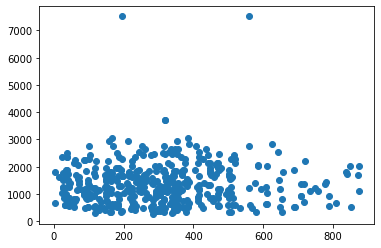

In [24]:
plt.scatter(df_rfm['recency'], df_rfm['monetary'])
plt.show()

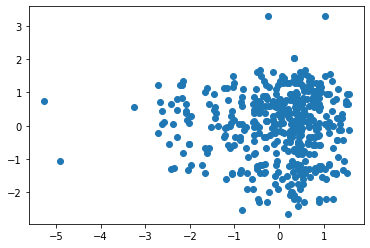

In [25]:
plt.scatter(X_norm[:,0], X_norm[:,2])
plt.show()

In [26]:
def k_means(X):
  sse = {}
  for k in range(1, 21):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0).fit(X)
    sse[k] = kmeans.inertia_

  kn = kneed.KneeLocator(
    x=list(sse.keys()), 
    y=list(sse.values()), 
    curve='convex', 
    direction='decreasing')
  
  kmeans = MiniBatchKMeans(n_clusters=kn.knee, random_state=0).fit(X)
  return kmeans

In [27]:
kmeans = k_means_modelling(df_wrag)

k-means model

In [28]:
centroid = kmeans.cluster_centers_

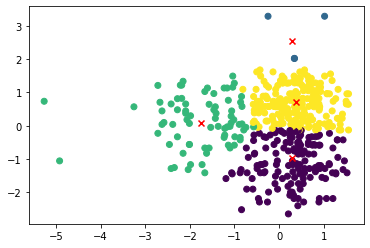

In [29]:
plt.scatter(X_norm[:,0], X_norm[:,2], c=kmeans.labels_)
plt.scatter(centroid[:,0], centroid[:,2], marker='x', color='r')
plt.show()

## **Agglomerative Clustering**

ต่อนำมา modelling กับ Agglomerative Clustering โดยใช้ kneed ที่เป็น automation ในการหาค่า k ที่ดีที่สุด และเพิ่ม Linkage แต่ละวิธีอย่างเช่น Ward, Complete-link, Average-link

In [30]:
def agglomerative_modelling(X, X_norm, lk):
  agg = agglomerative(X_norm, lk)
  X_agg = X.assign(cluster=agg.labels_)
  return agg

In [31]:
def agglomerative(X, lk):
  sse = {}
  for k in range(1, 21):
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=0).fit(X)
    sse[k] = kmeans.inertia_

  kn = kneed.KneeLocator(
    x=list(sse.keys()), 
    y=list(sse.values()), 
    curve='convex', 
    direction='decreasing')
  
  agg = AgglomerativeClustering(n_clusters=kn.knee, linkage=lk).fit(X)
  return agg

In [32]:
agg_ward = agglomerative_modelling(df_wrag, X_norm, 'ward')
agg_complete = agglomerative_modelling(df_wrag, X_norm, 'complete')
agg_average = agglomerative_modelling(df_wrag, X_norm, 'average')

Agglomerative (Ward)

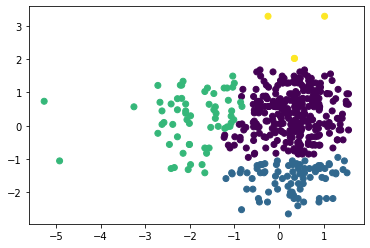

In [33]:
plt.scatter(X_norm[:,0], X_norm[:,2], c=agg_ward.labels_)
plt.show()

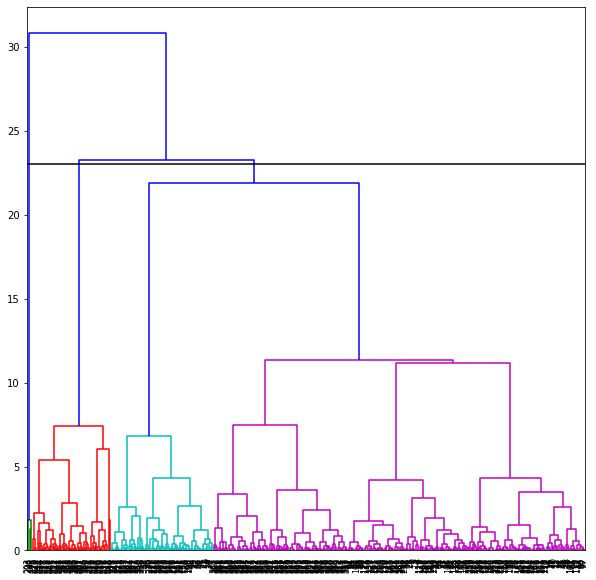

In [34]:
plt.figure(figsize = (10,10))
linkage_arr = ward(X_norm)
dendrogram(linkage_arr, leaf_rotation=90, leaf_font_size=8)
plt.axhline(y=23, c='k')

ax = plt.gca()
bounds = ax.get_xbound()
plt.show()

Agglomerative (Complete)

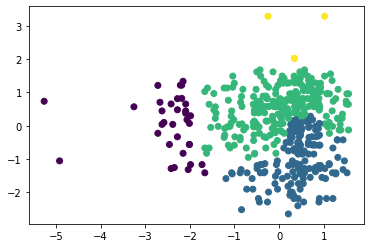

In [35]:
plt.scatter(X_norm[:,0], X_norm[:,2], c=agg_complete.labels_)
plt.show()

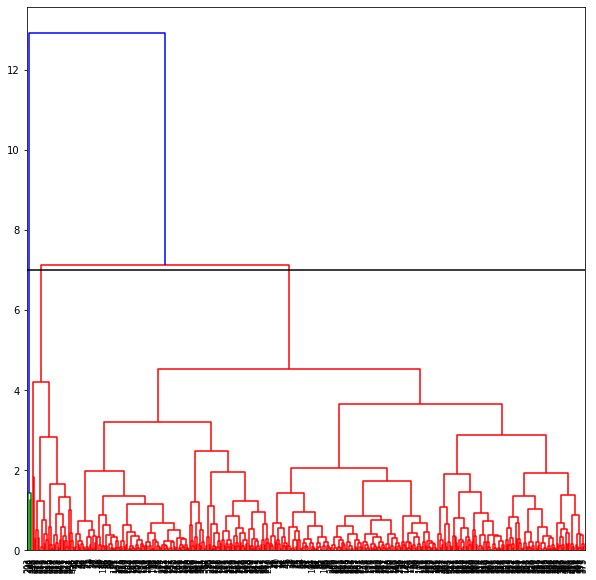

In [36]:
plt.figure(figsize = (10,10))
linkage_arr = complete(X_norm)
dendrogram(linkage_arr, leaf_rotation=90, leaf_font_size=8)
plt.axhline(y=7, c='k')

ax = plt.gca()
bounds = ax.get_xbound()
plt.show()

Agglomerative (Average)

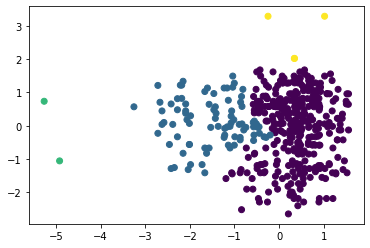

In [37]:
plt.scatter(X_norm[:,0], X_norm[:,2], c=agg_average.labels_)
plt.show()

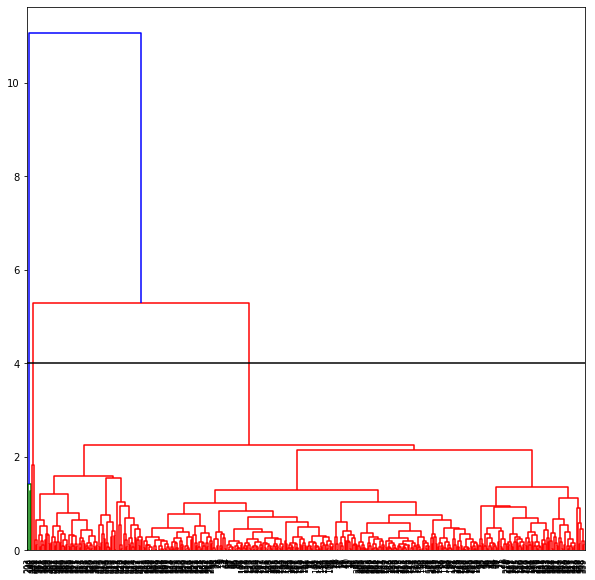

In [38]:
plt.figure(figsize = (10,10))
linkage_arr = average(X_norm)
dendrogram(linkage_arr, leaf_rotation=90, leaf_font_size=8)
plt.axhline(y=4, c='k')

ax = plt.gca()
bounds = ax.get_xbound()
plt.show()

## **Model Evaluation**

หลังจาก modelling ทั้งสองอัลกอริทึมเสร็จแล้ว นำมาประเมินผลโมเดล โดยใช้ Calinski Harabasz Score เพื่อหาว่าโมเดลไหนมีการกระจายตัวได้ดีที่สุด จึงกำหนดให้เป็นโมเดลหลัก จากนั้นทำ modelling แล้วนำข้อมูลหลังจากทำ Clustering มาบันทึกไฟล์

In [39]:
model = [kmeans, agg_ward, agg_complete, agg_average]
model_score = [calinski_harabasz_score(X_norm, kmeans.labels_),
               calinski_harabasz_score(X_norm, agg_ward.labels_),
               calinski_harabasz_score(X_norm, agg_complete.labels_),
               calinski_harabasz_score(X_norm, agg_average.labels_)]

In [40]:
print("Calinski-Harabasz score k-means : {:.4f}".format(calinski_harabasz_score(X_norm, kmeans.labels_)))
print("Calinski-Harabasz score Agglomerative (Ward): {:.4f}".format(calinski_harabasz_score(X_norm, agg_ward.labels_)))
print("Calinski-Harabasz score Agglomerative (Complete): {:.4f}".format(calinski_harabasz_score(X_norm, agg_complete.labels_)))
print("Calinski-Harabasz score Agglomerative (Average): {:.4f}".format(calinski_harabasz_score(X_norm, agg_average.labels_)))

Calinski-Harabasz score k-means : 472.4744
Calinski-Harabasz score Agglomerative (Ward): 410.5761
Calinski-Harabasz score Agglomerative (Complete): 332.2188
Calinski-Harabasz score Agglomerative (Average): 201.7055


In [41]:
def select_best_model(model, ms):
  maxpos = ms.index(max(ms))
  return model[maxpos]

In [42]:
best_model = select_best_model(model, model_score)

In [43]:
def save_file(X, X_norm):
  best_model = select_best_model(model, model_score)
  X_best = X.assign(cluster=best_model.labels_)
  X_best = X_best[['Customer_ID', 'cluster']]
  df_merge = X_best.merge(df_rfm, on='Customer_ID')
  df_merge.to_csv('Customer_Segmentation.csv')

In [44]:
save_file(df_wrag, X_norm)

## **Predict**

In [45]:
def clustering_data(order_source, oid, cid, pid, n, prom, date):
  p_id = ['THT0001', 'THT0002', 'THT0003', 'THT0004', 'THT0005',
          'THT0006', 'THT0007', 'THT0008', 'THT0009', 'THT0010',
          'THT0011', 'THT0012', 'THT0013', 'THT0014', 'THT0015',
          'THT0016', 'THT0017', 'THT0018', 'THT0019', 'THT0020']

  p_price = [250, 270, 290, 310, 330,
             350, 370, 390, 410, 430,
             450, 470, 490, 510, 530,
             550, 570, 590, 610, 630]
  
  p_dict = dict(zip(p_id, p_price))

  df_input = pd.DataFrame({'Order_Source':[order_source],
                           'Order_ID':[oid],
                           'Customer_ID':[cid],
                           'Product_ID':[pid],
                           'Product_Price':[p_dict[pid]],
                           'Quantity':[n],
                           'Promotion':[prom],
                           'TotalPrice':[p_dict[pid] * n],
                           'date':[datetime.strptime(date, '%Y-%m-%d').date()],})

  X_input = to_rfm_dataset(df_input)
  y_pred = predict_model(X_input)

  return y_pred

In [46]:
def to_rfm_dataset(input):
  df_input = df_clean.append(input, ignore_index = True)
  df_output = data_wagling(df_input)
  result = df_output[df_output['Customer_ID'] == input.loc[0, 'Customer_ID']].drop('Customer_ID', axis=1)
  result = result.values.tolist()
  return result

In [47]:
def predict_model(input):
  y_pred = best_model.predict(input)
  return y_pred[0]

In [48]:
clustering_data('Shopee', '9987', '75859', 'THT0001', 1, 'No', '2022-05-20')

1